In [1]:
# 필요 라이브러리 임포트

import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import urllib3
urllib3.disable_warnings()

In [2]:
# GPU 사용환경 확인

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# 데이터 가져오기

(ds_train, ds_test), ds_info = tfds.load('stanford_dogs', 
                                         split = ['train', 'test'], 
                                         shuffle_files = True, 
                                         with_info = True)

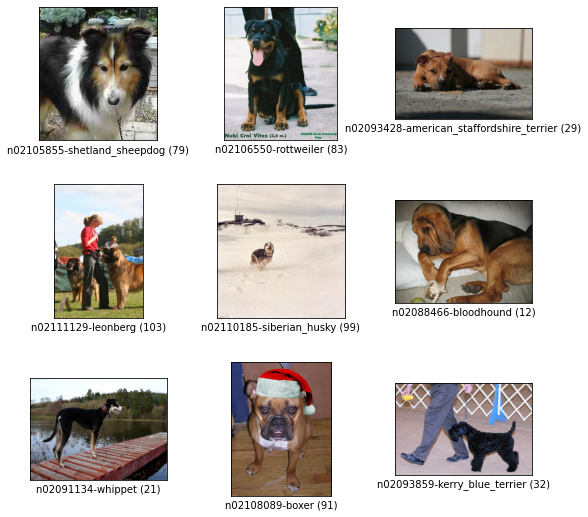

In [4]:
# 데이터 샘플 살펴보기

fig = tfds.show_examples(ds_train, ds_info)

In [5]:
# augmentation 적용을 위한 전처리 함수

def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [6]:
# random_augmentation 중 random_flip_left_right() 와 random_brightness() 적용

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta = 0.2)
    return image,label

In [7]:
# 위에서 구현한 함수를 통해 배치 단위의 CutMix 함수 구현

def cutmix(image, label, prob = 1.0, batch_size = 16, img_size = 224, num_classes = 120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_label

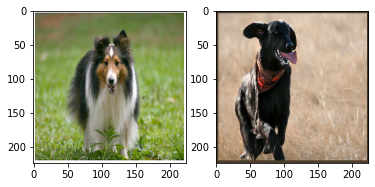

In [20]:
# CutMix 이미지 섞기

# 데이터 셋에서 2개의 이미지 가져오기

for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

In [24]:
# CutMix 라벨 섞기

# 섞인 이미지에 대해 라벨을 만들 때 적절한 비율로 라벨을 합쳐주는 함수 구현

# mix two labels
def mix_2_label(label_a, label_b, xa, ya, xb, yb, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (xb-xa) * (yb-ya)
    total_area = image_size_x * image_size_y
    a = tf.cast(mixed_area / total_area, tf.float32)

    if len(label_a.shape) == 0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape) == 0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

mixed_label = mix_2_label(label_a, label_b, xa, ya, xb, yb)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.22265625,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [8]:
# 배치단위의 MixUp 함수 구현

def mixup(image, label, prob = 1.0, batch_size = 16, img_size = 224, num_classes = 120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [21]:
# 첫번째 이미지 a를 바탕 이미지로 하고 거기에 삽입할 두번째 이미지 b가 있을 때, 
# a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수 구현

def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast( tf.random.uniform([],0, image_size_x),tf.int32)
    y = tf.cast( tf.random.uniform([],0, image_size_y),tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width // 2)
    ya = tf.math.maximum(0, y-height // 2)
    xb = tf.math.minimum(image_size_x, x+width // 2)
    yb = tf.math.minimum(image_size_y, y+width // 2)
    
    return xa, ya, xb, yb

xa, ya, xb, yb = get_clip_box(image_a, image_b)
print(xa, ya, xb, yb)

tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(114, shape=(), dtype=int32) tf.Tensor(98, shape=(), dtype=int32)


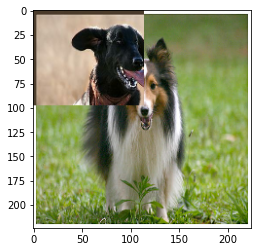

In [23]:
# 바탕이미지 a에서 바운딩 박스 바깥쪽 영역을, 
# 다른 이미지 b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수 구현

# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:image_size_x,:]
    middle = tf.concat([one,two,three],axis = 1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:image_size_y,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis = 0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
plt.imshow(mixed_img.numpy())

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.03605962 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.9639404  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

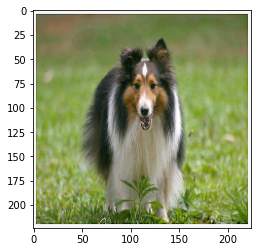

In [26]:
# MixUp Augmentation

# function for mixup

def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape) == 0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape) == 0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a) * image_a + a * image_b
    mixed_label = (1-a) * label_a + a * label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
print(mixed_label)

In [9]:
# onehot 인코딩

def onehot(image, label, num_classes = 120) : 
    label = tf.one_hot(label, num_classes)
    
    return image, label

In [16]:
# apply_normalize_on_dataset() : 다양한 형태로 가공한 형태의 새로운 데이터셋을 얻게 되는 모든 과정을 구현하는 메인 함수

# 일반적인 전처리 과정 (normalize, resize, augmentation, shuffle 적용)
# shiffle, augmentation 은 테스트 데이터셋에는 적용하지 않아야 한다.


# 데이터셋을 가공하는 메인함수 (with_aug 매개변수를 통해 augmentation 적용 여부를 결정)

def apply_normalize_on_dataset(ds, is_test = False, batch_size = 16, with_aug = False, with_cutmix = False, with_mixup = False):
    
    ds = ds.map(normalize_and_resize_img, num_parallel_calls = 2)
    
    if not is_test and with_aug:
        ds = ds.map(augment)
        
    ds = ds.batch(batch_size)
    
    if not is_test and with_cutmix:
        ds = ds.map(cutmix, num_parallel_calls = 2)
        
    elif not is_test and with_mixup : 
        ds = ds.map(mixup, num_parallel_calls = 2)
        
        
    else:
        ds = ds.map(onehot, num_parallel_calls = 2)
        
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

In [11]:
# Augumentation 을 적용한 데이터를 학습한 모델과 적용하지 않은 데이터를 학습한 모델의 성능 비교

# keras 의 ResNet50 중 imagenet 에 훈련도니 모델을 불러온다.
# include_top 은 마지막 fully connected layer 를 포함할지 여부
# 해당 레이어를 포함하지 않고 생성하면 feature extractor (특성 추출기) 부분만 불러와 
# 필요에 맞게 수정된 fully connected layer 를 붙여 활용 가능
# imagemet 과 테스트셋이 서로 다른 클래스를 가지기 때문에
# 마지막에 추가해야하는 fully connect layer 의 구조 (뉴런의 개수) 또한 다르다.

num_classes = ds_info.features['label'].num_classes

resnet50 = keras.models.Sequential([keras.applications.resnet.ResNet50(include_top = False, 
                                                                       weights = 'imagenet', 
                                                                       input_shape = (224, 224, 3), 
                                                                       pooling = 'avg'), 
                                    keras.layers.Dense(num_classes, activation = 'softmax')])

In [12]:
# Augmentation 을 적용한 데이터셋으로 학습시킬 ResNet 생성

aug_resnet50 = keras.models.Sequential([keras.applications.resnet.ResNet50(include_top = False, 
                                                                          weights = 'imagenet', 
                                                                          input_shape = (224, 224, 3), 
                                                                          pooling = 'avg'), 
                                       keras.layers.Dense(num_classes, activation = 'softmax')])

In [13]:
# Augmentation + cutmix 을 적용한 데이터셋으로 학습시킬 ResNet 생성

aug_cm_resnet50 = keras.models.Sequential([keras.applications.resnet.ResNet50(include_top = False, 
                                                                          weights = 'imagenet', 
                                                                          input_shape = (224, 224, 3), 
                                                                          pooling = 'avg'), 
                                       keras.layers.Dense(num_classes, activation = 'softmax')])

In [14]:
# Augmentation + mixup 을 적용한 데이터셋으로 학습시킬 ResNet 생성

aug_mu_resnet50 = keras.models.Sequential([keras.applications.resnet.ResNet50(include_top = False, 
                                                                          weights = 'imagenet', 
                                                                          input_shape = (224, 224, 3), 
                                                                          pooling = 'avg'), 
                                       keras.layers.Dense(num_classes, activation = 'softmax')])

In [27]:
# 텐서플로우 데이터에서 불러온 데이터에 apply_normalize_on_dataset() 에
# 하나는 with_aug 를 False 로,
# 다른 하나는 with_aug 를 True 로 설정

(ds_train, ds_test), ds_info = tfds.load('stanford_dogs', 
                                         split = ['train', 'test'], 
                                         as_supervised = True, 
                                         shuffle_files = True, 
                                         with_info = True)

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug = False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug = True)
ds_train_aug_cm = apply_normalize_on_dataset(ds_train, with_cutmix = True)
ds_train_aug_mu = apply_normalize_on_dataset(ds_train, with_mixup = True)

ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

In [28]:
# 모델 학습

EPOCH = 20

tf.random.set_seed(2020)
resnet50.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr = 0.01),
    metrics = ['accuracy'])

aug_resnet50.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr = 0.01),
    metrics = ['accuracy'])

aug_cm_resnet50.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr = 0.01),
    metrics = ['accuracy'])

aug_mu_resnet50.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr = 0.01),
    metrics = ['accuracy'])


history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch = int(ds_info.splits['train'].num_examples / 16),
    validation_steps = int(ds_info.splits['test'].num_examples / 16),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch = int(ds_info.splits['train'].num_examples / 16),
    validation_steps = int(ds_info.splits['test'].num_examples / 16),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True)

history_resnet50_aug_cm = aug_cm_resnet50.fit(
    ds_train_aug, # augmentation + cutmix 적용한 데이터셋 사용
    steps_per_epoch = int(ds_info.splits['train'].num_examples / 16),
    validation_steps = int(ds_info.splits['test'].num_examples / 16),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True)

history_resnet50_aug_mu = aug_mu_resnet50.fit(
    ds_train_aug, # augmentation + mixup 적용한 데이터셋 사용
    steps_per_epoch = int(ds_info.splits['train'].num_examples / 16),
    validation_steps = int(ds_info.splits['test'].num_examples / 16),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True)

Epoch 1/20
750/750 [==============================] - 118s 157ms/step - loss: 2.2370 - accuracy: 0.4439 - val_loss: 3.2502 - val_accuracy: 0.2240
Epoch 2/20
750/750 [==============================] - 128s 171ms/step - loss: 0.7923 - accuracy: 0.7726 - val_loss: 1.1497 - val_accuracy: 0.6679
Epoch 3/20
750/750 [==============================] - 126s 168ms/step - loss: 0.2884 - accuracy: 0.9331 - val_loss: 0.9978 - val_accuracy: 0.7044
Epoch 4/20
750/750 [==============================] - 121s 162ms/step - loss: 0.1001 - accuracy: 0.9870 - val_loss: 0.9412 - val_accuracy: 0.7284
Epoch 5/20
750/750 [==============================] - 131s 175ms/step - loss: 0.0427 - accuracy: 0.9969 - val_loss: 0.9328 - val_accuracy: 0.7338
Epoch 6/20
750/750 [==============================] - 140s 187ms/step - loss: 0.0350 - accuracy: 0.9975 - val_loss: 0.9525 - val_accuracy: 0.7317
Epoch 7/20
750/750 [==============================] - 127s 169ms/step - loss: 0.0137 - accuracy: 0.9996 - val_loss: 0.9473 -

750/750 [==============================] - 168s 224ms/step - loss: 2.2366 - accuracy: 0.4434 - val_loss: 2.9796 - val_accuracy: 0.2704
Epoch 2/20
750/750 [==============================] - 166s 222ms/step - loss: 0.9457 - accuracy: 0.7220 - val_loss: 1.2820 - val_accuracy: 0.6336
Epoch 3/20
750/750 [==============================] - 168s 223ms/step - loss: 0.5323 - accuracy: 0.8503 - val_loss: 1.0983 - val_accuracy: 0.6810
Epoch 4/20
750/750 [==============================] - 167s 223ms/step - loss: 0.3041 - accuracy: 0.9233 - val_loss: 1.0306 - val_accuracy: 0.7038
Epoch 5/20
750/750 [==============================] - 168s 224ms/step - loss: 0.1515 - accuracy: 0.9686 - val_loss: 1.0553 - val_accuracy: 0.7050
Epoch 6/20
750/750 [==============================] - 168s 224ms/step - loss: 0.1165 - accuracy: 0.9778 - val_loss: 1.0217 - val_accuracy: 0.7157
Epoch 7/20
750/750 [==============================] - 170s 226ms/step - loss: 0.0571 - accuracy: 0.9917 - val_loss: 0.9534 - val_accura

750/750 [==============================] - 162s 216ms/step - loss: 2.2687 - accuracy: 0.4352 - val_loss: 2.9627 - val_accuracy: 0.2761
Epoch 2/20
750/750 [==============================] - 131s 175ms/step - loss: 0.9571 - accuracy: 0.7225 - val_loss: 1.2142 - val_accuracy: 0.6486
Epoch 3/20
750/750 [==============================] - 123s 164ms/step - loss: 0.5353 - accuracy: 0.8508 - val_loss: 1.1264 - val_accuracy: 0.6749
Epoch 4/20
750/750 [==============================] - 224s 299ms/step - loss: 0.3254 - accuracy: 0.9147 - val_loss: 1.0798 - val_accuracy: 0.6910
Epoch 5/20
750/750 [==============================] - 267s 357ms/step - loss: 0.1869 - accuracy: 0.9570 - val_loss: 0.9996 - val_accuracy: 0.7192
Epoch 6/20
750/750 [==============================] - 268s 358ms/step - loss: 0.1091 - accuracy: 0.9793 - val_loss: 0.9944 - val_accuracy: 0.7228
Epoch 7/20
750/750 [==============================] - 237s 316ms/step - loss: 0.0779 - accuracy: 0.9872 - val_loss: 0.9806 - val_accura

750/750 [==============================] - 190s 253ms/step - loss: 2.2541 - accuracy: 0.4349 - val_loss: 2.9575 - val_accuracy: 0.2787
Epoch 2/20
750/750 [==============================] - 173s 231ms/step - loss: 0.9463 - accuracy: 0.7269 - val_loss: 1.4270 - val_accuracy: 0.5999
Epoch 3/20
750/750 [==============================] - 148s 198ms/step - loss: 0.5490 - accuracy: 0.8438 - val_loss: 1.5931 - val_accuracy: 0.5726
Epoch 4/20
750/750 [==============================] - 146s 195ms/step - loss: 0.3026 - accuracy: 0.9223 - val_loss: 1.1872 - val_accuracy: 0.6735
Epoch 5/20
750/750 [==============================] - 148s 197ms/step - loss: 0.1727 - accuracy: 0.9623 - val_loss: 0.9797 - val_accuracy: 0.7205
Epoch 6/20
750/750 [==============================] - 159s 211ms/step - loss: 0.0953 - accuracy: 0.9827 - val_loss: 0.9805 - val_accuracy: 0.7303
Epoch 7/20
750/750 [==============================] - 201s 269ms/step - loss: 0.0499 - accuracy: 0.9933 - val_loss: 0.9350 - val_accura

KeyError: 'val accuracy'

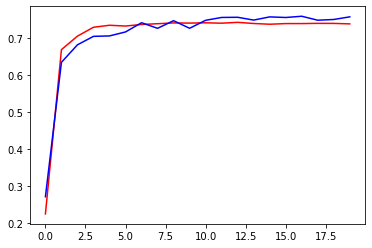

In [30]:
# 훈련과정 시각화

plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cm.history['val accuracy'], 'o')
plt.plot(history_resnet50_aug_mu.history['val_accuracy'], 'x')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Augmentation + CuxMix', 'With Augmentation + MixUp'], loc='upper left')
plt.show()

KeyError: 'val accuracy'

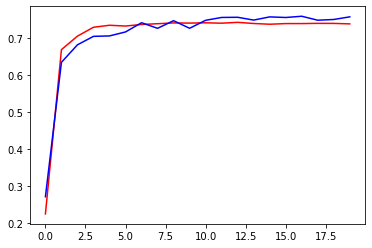

In [31]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cm.history['val accuracy'], 'o')
plt.plot(history_resnet50_aug_mu.history['val_accuracy'], 'x')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Augmentation + CuxMix', 'With Augmentation + MixUp'], loc='upper left')
plt.grid(True)
plt.ylim(0.72, 0.76)
plt.show()